# Equação de adveçcão

* Como primeiro exemplo de simulação numérica, vamos considerar a equação de advecção
$$ u_t + au_x = 0.
$$

In [9]:
using DifferentialEquations
using Plots

## Solução analítica da equação de advecção

* Vamos começar estudando a equação de advecção em uma dimensão:
$$ u_t + a u_x = 0
$$

* Vamos considerar o domínio $x\in \mathbb{R}$ e uma condição inicial $u_0(x)$.

* A solução dessa equação é simples:
$$ u(t,x) = u_0(x-at).
$$

* De fato, 
$$ u_t(t,x) = -au_0'(x-at), \quad u_x = u_0'(x-at), \quad \Longrightarrow u_t + au_x = -au_0'(x-at) + a u_0'(x-at) = 0.
$$

* Portanto, a solução é o deslocamento da condição inicial $u_0$ com velocidade constante $a$.

* Em aplicacões, $u_0(x)$ representa alguma quantidade no ponto $x$, digamos (densidade de) massa, calor, etc., que é então transportada com velocidade $a$.

* Caso $a>0$, a solução se desloca para a direita.

* Caso $a<0$, a solucão se desloca para a esquerda.

### Condições de contorno em domínios limitados

* Em domínios limitados, é preciso incluir condições de contorno.

* Uma das condições mais simples é assumir condições periódicas. Nesse caso, é como se o domínio fosse a reta toda e a condição inicial e a solução fossem copiadas infinitas vezes para os dois lados, de maneira periódica.

* Outras condições clássicas são a de Dirichlet, $u(t, \tilde x)=f(t)$, e a de Neumann, $u_x(t, \tilde x)=g(t)$, onde $\tilde x$ é um ponto no bordo.

* Mas nesses casos, como a condição inicial é transportada para um dos dois lados, dependento do sinal de $a$, só podemos impor a condição de contorno "no lado de origem", para evitar conflitos.

* Por exemplo, se o dominio é o intervalo $I=[0, L]$ e $a>0$, então só podemos impor $u(t,0)=f(t)$ ou $u_x(t,0)=g(t)$.  Se $a<0$, então só podemos impor $u(t,L)=f(t)$ ou $u_x(t,L)=g(t)$.

* No caso em que $f=0$, temos a condição de Dirichlet homogêna.

* No caso em que $g=0$, temos a condição de Neumann homogênea.

### Simulação de deslocamento para a direita

* Vamos assumir, aqui, condições de contorno periódicas.

* O intervalo espacial é $I=[0,2\pi]$, com condição inicial $u_0(x) = \sin(x)$.

* No caso de deslocamento para a direita, temos $a>0$.

* Nesse caso, vamos usar diferenças finitas "para frente".
$$ \partial_x u(x) \approx \frac{u(x+h) - u(x)}{h}
$$

* O uso de diferenças centradas ou para trás, nesse caso, nos leva a métodos instáveis.

In [10]:
"""
Operador de diferenças finitas para trás, com condições de contorno periódicas
"""
function δ⁻(u::Vector{Float64}, h::Float64, ::Val{:per})
    du = zero(u)
    for j = 2:length(u)
        du[j] = (u[j] - u[j-1])/h
    end
    du[1] = (u[1] - u[end])/h
    return du
end

δ⁻

In [11]:
function dudt_advection⁻!(dudt::Vector{Float64}, u::Vector{Float64},
        p::Vector{Float64}, t::Float64)
    a, h = p
    du = δ⁻(u, h, Val(:per))
    dudt .= - a * du
    return nothing
end

dudt_advection⁻! (generic function with 1 method)

In [12]:
a = 0.5 # # velocidade de propagação
L = 2π # comprimento do intervalo [0,L]
N = 60 # número de pontos da malha
h = L/(N-1) # comprimento de cada partição na malha
x = range(0.0, L, length=N) # discretização do intervalo [0,L] com N pontos, incluindo os extremos
u₀ = sin.(x) # condição inicial, com N pontos (incluindo os dois extremos)
p = [a, h] # parâmetros
Tf = L/a # tempo final (volta completa)
τ = 0.1 # intervalo de tempo para guardar a solução
tspan = (0.0,Tf) # intervalo de tempo
prob = ODEProblem(dudt_advection⁻!, u₀, tspan, p, saveat = τ)
nothing

In [13]:
sol = solve(prob, Tsit5())
sol.retcode

:Success

In [14]:
sol

retcode: Success
Interpolation: 1st order linear
t: 127-element Vector{Float64}:
  0.0
  0.1
  0.2
  0.30000000000000004
  0.4
  0.5
  0.6
  0.7000000000000001
  0.8
  0.9
  1.0
  1.1
  1.2000000000000002
  ⋮
 11.5
 11.6
 11.700000000000001
 11.8
 11.9
 12.0
 12.1
 12.200000000000001
 12.3
 12.4
 12.5
 12.566370614359172
u: 127-element Vector{Vector{Float64}}:
 [0.0, 0.1062934856473654, 0.21138262362962432, 0.31407671202194876, 0.41321218576837815, 0.5076658003388399, 0.5963673585385013, 0.6783118362696161, 0.7525707698561385, 0.818302775908169  …  -0.8183027759081689, -0.7525707698561385, -0.678311836269616, -0.5963673585385014, -0.5076658003388399, -0.4132121857683782, -0.3140767120219489, -0.21138262362962446, -0.1062934856473656, -2.4492935982947064e-16]
 [-0.010057738237594616, 0.06501077026477721, 0.163223305414004, 0.2657657931936173, 0.36630895192625346, 0.46282364675910964, 0.5541060018585185, 0.63911103850578, 0.7168747543854092, 0.7865159965125561  …  -0.8437100125058529, -0

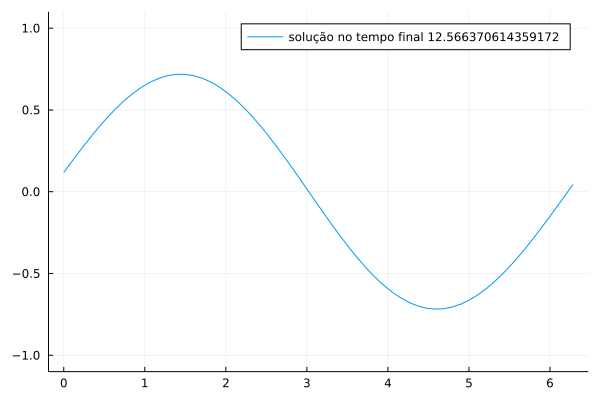

In [15]:
plot(x, sol.u[end], ylims=(-1.1, 1.1), label="solução no tempo final $(sol.t[end])")

In [16]:
anim = @animate for (t,u) in zip(sol.t, sol.u)
    plot(x, u, ylims=(-1.1, 1.1), label="t=$(round(t,digits=2))",
        title="Uma solução da equação de adveção com a=$a", titlefont=10)
end
gif(anim, "../../../assets/attachments/img/anim_adveccao_dir.gif", fps = 20)
nothing

┌ Info: Saved animation to 
│   fn = /Users/rmsrosa/Documents/git-repositories/modelagem_matematica/_assets/attachments/img/anim_adveccao_dir.gif
└ @ Plots /Users/rmsrosa/.julia/packages/Plots/MzlNY/src/animation.jl:130


![advection](../../../assets/attachments/img/anim_adveccao_dir.gif)

### Deslocamento para a esquerda

In [17]:
"""
Operador diferenças finitas para frente, com condições de contorno periódicas.
"""
function δ⁺(u, h, ::Val{:per})
    du = zero(u)
    for j = 1:length(u)-1
        du[j] = (u[j+1] - u[j])/h
    end
    du[end] = (u[1] - u[end])/h
    return du
end

δ⁺

In [18]:
function dudt_advection⁺!(dudt, u, p, t)
    a, h = p
    du = δ⁺(u, h, Val(:per))
    dudt .= - a * du
    return nothing
end

dudt_advection⁺! (generic function with 1 method)

In [19]:
a = -0.5 # velocidade de propagação
p = [a, h] # parâmetros
prob = ODEProblem(dudt_advection⁺!, u₀, tspan, p, saveat = τ)
sol = solve(prob, Tsit5())
sol.retcode

:Success

In [20]:
anim = @animate for (t,u) in zip(sol.t, sol.u)
    plot(x, u, ylims=(-1.1, 1.1), label="t=$(round(t,digits=2))",
        title="Uma solução da equação de adveção com a=$a", titlefont=10)
end
gif(anim, "../../../assets/attachments/img/anim_adveccao_esq.gif", fps = 20)
nothing

┌ Info: Saved animation to 
│   fn = /Users/rmsrosa/Documents/git-repositories/modelagem_matematica/_assets/attachments/img/anim_adveccao_esq.gif
└ @ Plots /Users/rmsrosa/.julia/packages/Plots/MzlNY/src/animation.jl:130


![advection left](../../../assets/attachments/img/anim_adveccao_esq.gif)

## Exercícios

1. Implemente o operador diferenças finitas para trás com condições de contorno de Dirichlet homogênea $u(0)=0$ e faça a simulação para algum parâmetro $a>0$.

1. Implemente o operador diferenças finitas para frente com condições de contorno de Dirichlet homogênea $u(0)=0$, faça a simulação no caso $a>0$ e observe a instabilidade do método nesse caso.

1. Implemente o operador diferenças finitas para frente com condições de contorno de Neumann homogênea $u'(L)=0$ e faça a simulação para algum parâmetro $a<0$.

1. Implemente o operador diferenças finitas para trás com condições de contorno de Neumann não-homogênea $u'(0)=b$, com um novo parâmetro $b>0$, e faça a simulação para algum parâmetro $a>0$.

1. Implemente o operador diferenças centradas, com condições de contorno periódicas, faça a simulação para algum parâmetro $a>0$ e observe a instabilidade do método.

1. Com condições de contorno periódicas, em um intervalo $I$, mostre que a "massa" $\int_I u(t,x)\;\mathrm{d}x$ é constante em $t$.

1. Da mesma forma, mostre que $\int_I u^n(t,x)\;\mathrm{d}x$ também é constante em $t$, para todo $n\in \mathbb{N}$.

1. Calcule $m[k] = \sum_i u(k\tau,x_i)h$, $k=1, \ldots$, no exemplo de condições periódicas de contorno e observe a evolução dessa quantidade através de um gráfico.